In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d

# to delete files, for animations
import os
# for generating animations in parallel
from pathos.multiprocessing import ProcessPool

In [2]:
# unit conversion
inchToMm = 2.54 * 10.

# Mirror input

In [3]:
# Blank diameter [mm]
D = 10. * inchToMm

# Focal length [mm]
fNumber = 5.   # "f number"
lf = D*fNumber # [mm]

# Depth of the blank [mm]
depth = D / 6.

In [4]:
########################################################################
# Equations for the circle and parabola, for a given circle radius Rc

def zCircCenter(Rc):
   """Height of the circle center [mm]
   Rc: circle radius [mm]
   """
   return np.sqrt(Rc**2 - (D/2.)**2)


def zCirc(r, Rc):
   """Equation for the circle.
   Rc: circle radius [mm]
   r: polar coordinate [mm]
   Output: height z [mm]
   """
   result = zCircCenter(Rc)
   result -= np.sqrt(Rc**2 - r**2)
   return result


def rContact(Rc):
   """Polar radius [mm] of the contact point between the circle and parabola.
   """
   return np.sqrt(Rc**2 - 4.*lf**2)

def sagittaCirc(Rc):
   """Maximum depth of the sphere [mm],
   given the radius Rc [mm]
   """
   result = Rc - zCircCenter(Rc)
   return result


########################################################################
# Equation for parabola

def zParaOffset(Rc):
   """Vertical offset [mm] for the parabola,
   to be tangent to the circle at the desired polar radius.
   Rc: circle radius [mm]
   """
   rC = rContact(Rc)
   result = zCircCenter(Rc)
   result -= np.sqrt(Rc**2 - rC**2)
   result -= rC**2 / (4.*lf)
   return result

def zFocus(Rc):
   """Height [mm] of the focal point of the parabola,
   given the circle radius Rc [mm]
   """
   result = zParaOffset(Rc) + lf
   return result

def zPara(r, Rc):
   """Equation for the parabola,
   with vertical offset determined to be tangent to the circle of radius Rc
   """
   result = zParaOffset(Rc)
   result += r**2 / (4. * lf)
   return result

def dzPara(r, Rc):
   """First derivative of the parabola
   """
   result = 2. * r / (4. * lf)
   return result

def d2zPara(r, Rc):
   """Second derivative of the parabola
   """
   result = 2. / (4. * lf)
   return result

def rCurv(r, Rc):
   """Radius of curvature of the parabola
   """
   result = (1. + dzPara(r, Rc)**2)**(3./2.)
   result /= np.abs(d2zPara(r, Rc))
   return result


########################################################################
# Find the circle radius Rc, to have the desired rContact = alpha * D/2
# Wisdom says alpha = 0.7

def RcForContact(alpha):
   """Find Rc needed for contact at rContact = alpha * D/2
   """
   result = (alpha*D/2.)**2
   result += 4. * lf**2
   return np.sqrt(result)

# Typical wisdom is to have the contact point at 70%
# of the radius of the blank
Rc70 = RcForContact(0.7)


########################################################################
# Find the circle radius that minimizes the volume between the parabola and the circle

def dVolumedRc(Rc):
   """Quantity proportional to the derivative of the volume between circle and parabola,
   with respect to the circle radius.
   Find the root of this function to minimize the volume between the sphere
   and paraboloid.
   """
   beta = Rc / (D/2.)
   result = 1. - np.sqrt(1. - 1./beta**2)
   result -= 1. / (8.*beta*fNumber)
   return result


# guess for the circle radius: twice the focal length
RcGuess = 2. * D * fNumber
RcBest = optimize.brentq(dVolumedRc , 0.9*RcGuess, 1.1*RcGuess)
rContactBest = rContact(RcBest)
alphaBest = rContactBest/(D/2.)

# Derived mirror specs

In [11]:
print("Primary diameter =", D, "mm =", D / inchToMm, "inch")
print("Aperture area =", np.round(np.pi*(0.1*D/2.)**2, 1), "cm^2,")
print("ie ", int((D/7.)**2), "times the area of fully dilated eye pupil (7mm)")
print("ie limiting apparent magnitude is", np.round(6 + 2.512*np.log10((D/7.)**2), 1))
print("compared to 6 for the naked eye.")

resBlueArcsec = 1.22 * 400.e-9/(D*1.e-3) * (180.*3600./np.pi)
resRedArcsec = 1.22 * 800.e-9/(D*1.e-3) * (180.*3600./np.pi)
print("Diffraction limit =", np.round(resBlueArcsec, 2), "arcsec in blue and ", np.round(resRedArcsec, 2), "arcsec in red")

print("")
print("f number =", fNumber)
print("focal length =", lf, "mm =", lf / inchToMm, "inch")
print("Min useful magnification, for fully dilated eye pupil (7mm) =", np.round(D/7.,1))
print("ie max useful eyepiece focal length =", np.round(7. * fNumber,1), "mm")
print("Magnification =", np.round(lf/10.,1), np.round(lf/20.,1), np.round(lf/35.,1), "for 10 20 30mm eyepiece focal length")

print("")
print("To minimize the volume between sphere and paraboloid,")
print("the contact point should be at a fraction", np.round(alphaBest, 4), "of the blank radius.")
print("The wisdom is 0.7.")

print("Hence the best circle radius =", np.round(RcBest, 3), "mm =", np.round(RcBest/inchToMm, 3), "inch")
print("The guess would be twice the focal length, ie", RcGuess, "mm =", np.round(RcGuess/inchToMm, 3), "inch")

print("Circle sagitta =", np.round(sagittaCirc(RcBest),5), "mm =", np.round(sagittaCirc(RcBest) / inchToMm,5), "inch")

Primary diameter = 254.0 mm = 10.0 inch
Aperture area = 506.7 cm^2,
ie  1316 times the area of fully dilated eye pupil (7mm)
ie limiting apparent magnitude is 13.8
compared to 6 for the naked eye.
Diffraction limit = 0.4 arcsec in blue and  0.79 arcsec in red

f number = 5.0
focal length = 1270.0 mm = 50.0 inch
Min useful magnification, for fully dilated eye pupil (7mm) = 36.3
ie max useful eyepiece focal length = 35.0 mm
Magnification = 127.0 63.5 36.3 for 10 20 30mm eyepiece focal length

To minimize the volume between sphere and paraboloid,
the contact point should be at a fraction 0.7072 of the blank radius.
The wisdom is 0.7.
Hence the best circle radius = 2541.587 mm = 100.062 inch
The guess would be twice the focal length, ie 2540.0 mm = 100.0 inch
Circle sagitta = 3.175 mm = 0.125 inch


# Plot the mirror curve

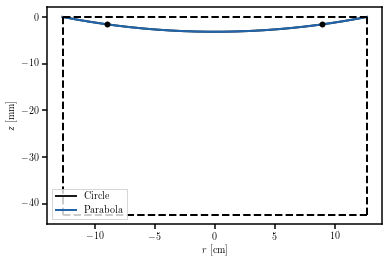

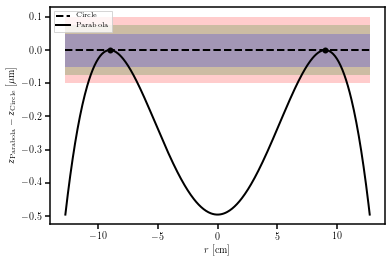

In [12]:
R = np.linspace(-D/2., D/2., 501)
ZCirc = zCirc(R, RcBest)
ZPara = zPara(R, RcBest)


fig=plt.figure(0)
ax=fig.add_subplot(111)
#
# Circle
ax.plot(R*0.1, ZCirc, label=r'Circle')
# Parabola
ax.plot(R*0.1, ZPara, label=r'Parabola')
#
# Contact points
ax.plot(np.array([-rContactBest, rContactBest])*0.1, [zCirc(rContactBest, RcBest), zCirc(rContactBest, RcBest)], 'ko')
#
# Blank
ax.plot(R*0.1, np.zeros_like(R), 'k--')
ax.plot(R*0.1, -depth * np.ones_like(R), 'k--')
ax.plot(np.array([-D/2., -D/2.])*0.1, [-depth, 0.], 'k--')
ax.plot(np.array([D/2., D/2.])*0.1, [-depth, 0.], 'k--')
#
ax.legend(loc=3)
ax.set_xlabel(r'$r$ [cm]')
ax.set_ylabel(r'$z$ [mm]')
#
fig.savefig("./figures/circle.pdf", bbox_inches='tight')



fig=plt.figure(1)
ax=fig.add_subplot(111)
#
# Show tolerances for red, green and blue wavelengths:
# should be wavelength/8 to reach the Rayleigh criterion for a miror,
# and wavelength/4 for a lens
tol = 8.
ax.fill_between(R*0.1, -800.e-3/tol, 800.e-3/tol, edgecolor=None, facecolor='r', alpha=0.2)
ax.fill_between(R*0.1, -600.e-3/tol, 600.e-3/tol, edgecolor=None, facecolor='g', alpha=0.2)
ax.fill_between(R*0.1, -400.e-3/tol, 400.e-3/tol, edgecolor=None, facecolor='b', alpha=0.2)
#
# Compare circle and parabola
ax.plot(R*0.1, 0.*R, 'k--', label=r'Circle')
ax.plot(R*0.1, (ZPara - ZCirc)*1.e3, 'k', label=r'Parabola')
#
# Contact points
ax.plot(np.array([-rContactBest, rContactBest])*0.1, [0., 0.], 'ko')
#
ax.legend(loc=2, fontsize='x-small')
ax.set_xlabel(r'$r$ [cm]')
ax.set_ylabel(r'$z_\text{Parabola} - z_\text{Circle}$ [$\mu$m]')
#
fig.savefig("./figures/parabola_vs_circle.pdf", bbox_inches='tight')

plt.show()

# Spherical aberration needed for a source at the center of sphere

In [13]:
def zIntercept(zS, r0, RcBest):
   '''Compute the height of the tip of the reflected cone, when
   zS: height of the light source (LED) [mm] 
   r0: the light reflects on the mirror annulus at radius r0
   RcBest: defines the parabolic mirror curve
   '''
   # given the parabolic mirror curve,
   # height of the mirror annulus at r0 [mm]
   z0 = zPara(r0, RcBest)
   dz0 = dzPara(r0, RcBest)
   # vector u, incident light vector
   # from the light source to the mirror annulus
   u = np.array([r0 - 0., z0 - zS])
   # vector t, tangent to the parabolic mirror
   # at the given annulus, outwards
   t = np.array([1., dz0])
   t /= np.sqrt(np.sum(t**2))
   # vector n, normal to the parabolic mirror
   # at the given annulus, upwards
   n = np.array([-dz0, 1.])
   n /= np.sqrt(np.sum(n**2))
   # vector v, reflected light vector
   # from the mirror annulus to the intercept point
   v = np.dot(u, t) * t - np.dot(u, n) * n
   # height of the intercept,
   # where the reflected light hits the optical axis
   result = z0 - r0 * v[1]/v[0]
   return result


/var/folders/yv/l45zjwhd6c9115whr40r77kc0000gn/T/ipykernel_40264/2876382393.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = z0 - r0 * v[1]/v[0]


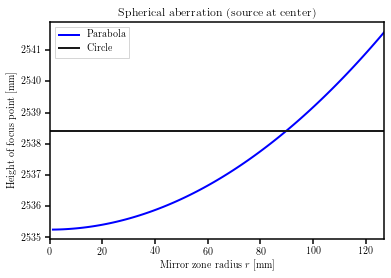

In [42]:
# Zones on the disk
R0 = np.linspace(0., D/2., 101)
# consider a light source at the center of the best Sphere
zS = zCircCenter(RcBest)
# computing the heights of the focus points for each zone
f = lambda r0:  zIntercept(zS, r0, RcBest)
ZFocus = np.array(list(map(f, R0)))

# Plot it!
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.plot(R0, ZFocus, 'b', label=r'Parabola')
ax.axhline(zCircCenter(RcBest), label='Circle')
#
ax.legend(loc=2)
ax.set_xlim((0., D/2.))
ax.set_xlabel(r'Mirror zone radius $r$ [mm]')
ax.set_ylabel(r'Height of focus point [mm]')
ax.set_title(r'Spherical aberration (source at center)')

fig.savefig("./figures/spherical_aberration.pdf", bbox_inches='tight')
# fig.clf()
plt.show()

# Ronchi / Foucault / wire test simulator

In [37]:
lambdaFringe = 0.254 # [mm]

def cosFringe(x, lambdaFringe=lambdaFringe):
   ''' Fringe pattern on the grating
   x: cartesian coordinate [mm]
   lambdaFringe: period of the grating pattern [mm]
   Centered on one dark fringe.
   '''
   return 0.5 * (1. - np.cos(2.*np.pi/lambdaFringe * x))

def stepFringe(x, lambdaFringe=lambdaFringe):
   ''' Fringe pattern on the grating
   x: cartesian coordinate [mm]
   lambdaFringe: period of the grating pattern [mm]
   Centered on one dark fringe.
   '''
   return 1.*((x/lambdaFringe-0.25) % 1 <0.5) #-1.*(x/lambdaFringe % 1 >0.5)


def createImage(zS, zGrating, test='Ronchi', fringe=stepFringe, lambdaFringe=lambdaFringe, nX=2001):
   '''Compute a Ronchi image
   zS: height of light source (LED) [mm]
   zGrating: height of the grating [mm]
   fringe: function defining the fringe pattern on the grating
   nX: number of pixels in image
   '''

   # Cartesian coordinates [mm], not angular coordinates
   # this way, for a perfect sphere, the stripes are perfectly parallel and vertical
   x = np.linspace(-D/2., D/2., nX)
   y = np.linspace(-D/2., D/2., nX)

   ## distortions to fit an actual real life photo
   ## apply a rotation if needed
   #rot = [[cos t, -sint], [sin t, cos t]]
   ## apply a shear if needed
   #shear = [[1. + gamma1, gamma2], [gamma2, 1. - gamma1]]
   ## apply a translation
   #x += dx
   #y += dy

   xx, yy = np.meshgrid(x, y, indexing='ij')
   rr = np.sqrt(xx**2 + yy**2)

   # height of the mirror surface at a given radius
   zz0 = zPara(rr, RcBest)

   f = np.vectorize( lambda r: zIntercept(zS, r, RcBest) ) 
   # for speed, interpolate on 1d array
   R = np.linspace(0., D, 2*nX)
   F = f(R)
   fInterp = interp1d(R, F, kind='linear', bounds_error=False, fill_value=0.)
   # then evaluate on 2d array
   zzIntercept = fInterp(rr)  #np.array(map(f, rr))
   
   if test=='Ronchi':
#      image = fringe(xx * np.abs(1. - zGrating/zzIntercept), lambdaFringe=lambdaFringe)
      image = fringe(xx * np.abs(zzIntercept - zGrating)/(zzIntercept - zz0), lambdaFringe=lambdaFringe)
   elif test=='Foucault':
      image = (zzIntercept >= zGrating) * (xx>=0.) + (zzIntercept <= zGrating) * (xx<0.)
      #image = 2. * image - 1.
   elif test=='Manu':
      image = fringe(xx * np.abs(zzIntercept - zGrating)/(zzIntercept - zz0), lambdaFringe=lambdaFringe)
      image *= fringe(yy * np.abs(zzIntercept - zGrating)/(zzIntercept - zz0), lambdaFringe=lambdaFringe)
   elif test=='Wire':
      width = 0.05   # [mm], determined by (but not equal to) the wire thickness
      image = 1. * (np.abs(zzIntercept-zGrating)>width) * (np.abs(xx)>width)

   image *= (rr < D/2.)

   # pcolor wants x and y to be edges of cell,
   # ie one more element, and offset by half a cell
   dX = D / (nX-1)
   xEdges = dX * (np.arange(nX+1) - 0.5)
   yEdges = xEdges.copy()
   xxEdges, yyEdges = np.meshgrid(xEdges, yEdges, indexing='ij')
   
   # return arrays needed by pcolormesh to plot
   return xxEdges, yyEdges, image

# Example Ronchi test

/var/folders/yv/l45zjwhd6c9115whr40r77kc0000gn/T/ipykernel_40264/2876382393.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = z0 - r0 * v[1]/v[0]
/var/folders/yv/l45zjwhd6c9115whr40r77kc0000gn/T/ipykernel_40264/3366429074.py:17: RuntimeWarning: invalid value encountered in remainder
  return 1.*((x/lambdaFringe-0.25) % 1 <0.5) #-1.*(x/lambdaFringe % 1 >0.5)


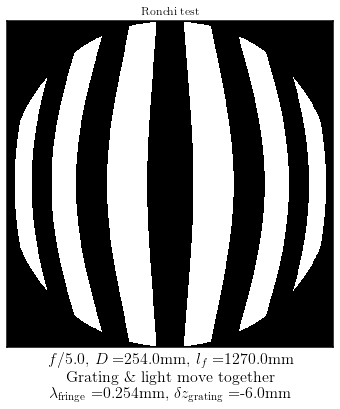

In [38]:
# Ronchi test
# height of the Ronchi grating:
# just a bit away from the center of the sphere
zGrating = zCircCenter(RcBest) - 6. # [mm]
# light source position
# zS = zCircCenter(RcBest)
zS = zGrating
xxEdges, yyEdges, image = createImage(zS, zGrating, test='Ronchi', fringe=stepFringe, nX=1001)


fig=plt.figure(0, figsize=(6,6))
ax=fig.add_subplot(111)
#
# outline of the mirror
circle = plt.Circle((0.5*D, 0.5*D), 0.5*D, ec='w', fc='none')
ax.add_artist(circle)
# mirror test
cp=ax.pcolormesh(xxEdges, yyEdges, image, linewidth=0, rasterized=True)
cp.set_cmap('binary_r')
ax
#
ax.set_title("Ronchi test")
ax.set_xlabel(r"$f/$"+str(fNumber)+r", $D=$"+str(D)+"mm, $l_f=$"+str(round(lf, 1))+"mm"+"\n"+"Grating \& light move together"+" \n"+r"$\lambda_\text{fringe}=$"+str(lambdaFringe)+r"mm, $\delta z_\text{grating}=$"+str(round(zGrating-zCircCenter(RcBest), 1))+"mm", fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.set_xlim((-D/2., D/2.))
ax.set_ylim((-D/2., D/2.))
ax.axis('scaled')

plt.show()

# Example Foucault test

/var/folders/yv/l45zjwhd6c9115whr40r77kc0000gn/T/ipykernel_40264/2876382393.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = z0 - r0 * v[1]/v[0]


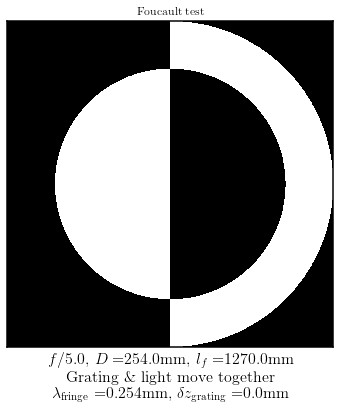

In [39]:
# Foucault
zGrating = zCircCenter(RcBest)
zS = 1. * zGrating
xxEdges, yyEdges, image = createImage(zCircCenter(RcBest), zCircCenter(RcBest), test='Foucault')


fig=plt.figure(0, figsize=(6,6))
ax=fig.add_subplot(111)
#
# outline of the mirror
circle = plt.Circle((0.5*D, 0.5*D), 0.5*D, ec='w', fc='none')
ax.add_artist(circle)
# mirror test
cp=ax.pcolormesh(xxEdges, yyEdges, image, linewidth=0, rasterized=True)
cp.set_cmap('binary_r')
ax
#
ax.set_title("Foucault test")
ax.set_xlabel(r"$f/$"+str(fNumber)+r", $D=$"+str(D)+"mm, $l_f=$"+str(round(lf, 1))+"mm"+"\n"+"Grating \& light move together"+" \n"+r"$\lambda_\text{fringe}=$"+str(lambdaFringe)+r"mm, $\delta z_\text{grating}=$"+str(round(zGrating-zCircCenter(RcBest), 1))+"mm", fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.set_xlim((-D/2., D/2.))
ax.set_ylim((-D/2., D/2.))
ax.axis('scaled')

plt.show()

# Create video animations

In [43]:
# video parameters
fps = 30 # [1/sec]
duration = 3   # [sec]
nFrames = fps * duration   # [dimless]

def CreateMovie(saveFrame, nFrames, fps, test='Ronchi', fixedLight=True, fringe=stepFringe, nX=1001):
   '''Generate all the frames, create the video,
   then delete the individual frames.
   '''
   # file name for the final animation
   if fixedLight:
      name = test + "_fixedlight"
   else:
      name = test + "_samelightgrating" 

   print("Generate all frames")
   f = lambda iFrame: saveFrame(iFrame, './figures/test_simulations/_tmp%05d.jpg'%iFrame, test=test, fixedLight=fixedLight)
   pool = ProcessPool(nodes=3)
   pool.map(f, range(nFrames))

   print("Resize images")
   # resize the images to have even pixel sizes on both dimensions, important for ffmpeg
   # this commands preserves the aspect ratio, rescales the image to fill HD as much as possible,
   # without cropping, then pads the rest with white
   for iFrame in range(nFrames):
      fname = './figures/test_simulations/_tmp%05d.jpg'%iFrame 
      #os.system("convert "+fname+" -resize 1280x720 -gravity center -extent 1280x720 -background white "+fname)
      os.system("convert "+fname+" -resize 1000x1000 -gravity center -extent 1000x1000 -background white "+fname)

   # delete old animation
   os.system("rm ./figures/test_simulations/"+name+".mp4")
   print("Create new animation")
   #os.system("ffmpeg -r "+str(fps)+" -i ./figures/test_simulations/_tmp%05d.jpg -s 1280x720 -vcodec libx264 -pix_fmt yuv420p ./figures/test_simulations/ronchi.mp4")
   os.system("ffmpeg -r "+str(fps)+" -i ./figures/test_simulations/_tmp%05d.jpg -s 1000x1000 -vcodec libx264 -pix_fmt yuv420p ./figures/test_simulations/"+name+".mp4")


   # delete images
   os.system("rm ./figures/test_simulations/_tmp*.jpg")




# Physical param to vary during animation,
# here zGrating [mm]
tMin = -20.
tMax = 20.

# Update function for the plot
def saveFrame(iFrame, fname, test='Ronchi', fixedLight=True, fringe=stepFringe, nX=1001):
   '''Updates the plot as needed for the frame iFrame.
   '''

   # Translate iFrame into the physical param of interest
   x = float(iFrame) / (nFrames - 1)
   t = tMin * (1.-x) + tMax * x
   print("frame="+str(iFrame)+", value="+str(t))

   # Update the image
   zGrating = zCircCenter(RcBest) + t # [mm]
   if fixedLight:
      # Here the grating moves, but the light source is fixed
      zS = zCircCenter(RcBest)
   else:
      # here the grating and the light move together
      zS = zGrating
   xxEdges, yyEdges, image = createImage(zS, zGrating, test=test, fringe=fringe, nX=nX)

   # Create the plot 
   fig=plt.figure(0, figsize=(6,6), dpi=300)
   ax=fig.add_subplot(111)
   #
   # outline of the mirror
   circle = plt.Circle((0.5*D, 0.5*D), 0.5*D, ec='w', fc='none')
   ax.add_artist(circle)
   # mirror test
   cp=ax.pcolormesh(xxEdges, yyEdges, image, linewidth=0, rasterized=True)
   cp.set_cmap('binary_r')
   #
   ax.set_title(test+" test")
   ax.set_xlabel(r"$f/$"+str(fNumber)+r", $D=$"+str(D)+"mm, $l_f=$"+str(round(lf, 1))+"mm"+"\n"+"Grating \& light move together"+" \n"+r"$\lambda_\text{fringe}=$"+str(lambdaFringe)+r"mm, $\delta z_\text{grating}=$"+str(round(zGrating-zCircCenter(RcBest), 1))+"mm", fontsize=16)
   plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
   plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
   ax.set_xlim((-D/2., D/2.))
   ax.set_ylim((-D/2., D/2.))
   ax.axis('scaled')
   #
   fig.savefig(fname, dpi=300)
   fig.clf()
   

# Generate the animations and save to file

In [ ]:
# Ronchi, fixed light
CreateMovie(saveFrame, nFrames, fps, test='Ronchi', fixedLight=True, fringe=stepFringe, nX=1001)
# Ronchi, light and grating move together
CreateMovie(saveFrame, nFrames, fps, test='Ronchi', fixedLight=False, fringe=stepFringe, nX=1001)

# Foucault, fixed light
CreateMovie(saveFrame, nFrames, fps, test='Foucault', fixedLight=True, fringe=stepFringe, nX=1001)
# Foucault, light and grating move together
CreateMovie(saveFrame, nFrames, fps, test='Foucault', fixedLight=False, fringe=stepFringe, nX=1001)

# Wire test, fixed light
CreateMovie(saveFrame, nFrames, fps, test='Wire', fixedLight=True, fringe=stepFringe, nX=1001)
# Wire test, light and grating move together
CreateMovie(saveFrame, nFrames, fps, test='Wire', fixedLight=False, fringe=stepFringe, nX=1001)

## Manu, fixed light
#CreateMovie(saveFrame, nFrames, fps, test='Manu', fixedLight=True, fringe=stepFringe, nX=1001)
## Manu, light and grating move together
#CreateMovie(saveFrame, nFrames, fps, test='Manu', fixedLight=False, fringe=stepFringe, nX=1001)